GPy tutorial, based on https://katbailey.github.io/post/gaussian-processes-for-dummies/

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import GPy

In [2]:
# reset random number generator
np.random.seed(10)

In [3]:
# define test data (_s stands for \star)
x_min=0
x_max=4
n_s = 81
x_s = np.linspace(x_min,x_max,n_s).reshape(-1,1)

In [4]:
# Define the kernel function
def SE_kernel(x_1, x_2, length):
    sqdist = np.sum(x_1**2,1).reshape(-1,1) + np.sum(x_2**2,1) - 2*np.dot(x_1, x_2.T)
    return np.exp(-.5 * (1/length**2) * sqdist)

In [5]:
length = 0.2
# covariance of test points
K_ss = SE_kernel(x_s, x_s, length)

In [6]:
# Get cholesky decomposition (square root) of the covariance matrix
noise_floor=1.e-12
L_ss = np.linalg.cholesky(K_ss + noise_floor*np.eye(n_s))

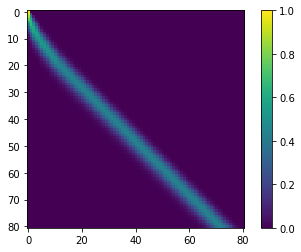

In [7]:
plt.imshow(L_ss)
plt.colorbar()
plt.show()

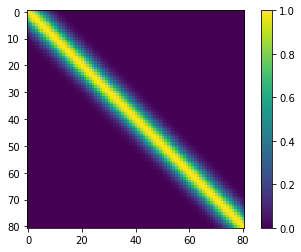

In [8]:
plt.imshow(K_ss)
plt.colorbar()
plt.show()

In [9]:
# Draw three functions from the prior
f_s_prior = np.dot(L_ss, np.random.normal(size=(n_s,3)))

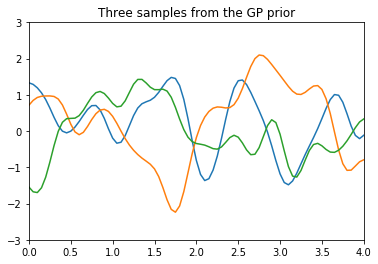

In [10]:
# Now let's plot the 3 sampled functions.
plt.plot(x_s, f_s_prior)
plt.axis([x_min,x_max, -3, 3])
plt.title('Three samples from the GP prior')
plt.show()

In [11]:
# define truth underlying function we are trying to model
def true_function(x):
    return np.sin(x)

In [12]:
# training data (_t stands for training)
x_t = [x_min+0.5, x_min+0.8,x_min+1, x_min+3]
n_t = len(x_t)
x_t = np.array(x_t).reshape(n_t,1)
# noise variance
noise_var=1.e-10
y_t = true_function(x_t) + np.sqrt(noise_var)*np.random.normal(n_t)

In [13]:
# Apply the kernel function to our training points
K_tt = SE_kernel(x_t, x_t, length)
C_tt = K_tt + noise_var*np.eye(n_t)
L_tt = np.linalg.cholesky(C_tt)

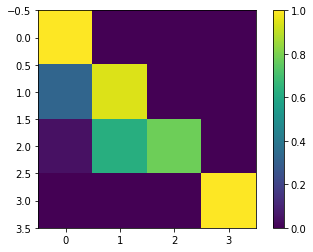

In [14]:
plt.imshow(L_tt)
plt.colorbar()
plt.show()

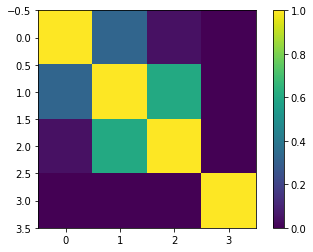

In [15]:
plt.imshow(K_tt)
plt.colorbar()
plt.show()

In [16]:
# Compute covariance between training and test (star) points
K_ts = SE_kernel(x_t, x_s, length)
# solve for M in L_tt M_ts = K_ts, i.e., L_tt^-1 K_ts
M_ts = np.linalg.solve(L_tt, K_ts)
# solve for z in L_tt z_t = y_t, i.e., L_tt^-1 y_t
z_t = np.linalg.solve(L_tt, y_t)

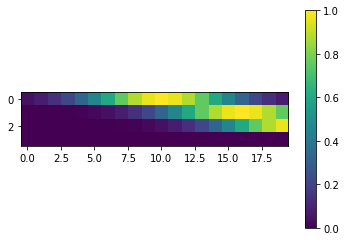

In [17]:
plt.imshow(K_ts[:,0:20])
plt.colorbar()
plt.show()

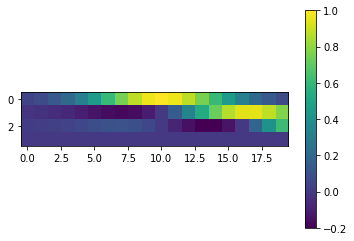

In [18]:
plt.imshow(M_ts[:,0:20])
plt.colorbar()
plt.show()

In [19]:
# Compute the mean at our test (star) points
f_s = np.dot(M_ts.T, z_t).reshape((n_s,))

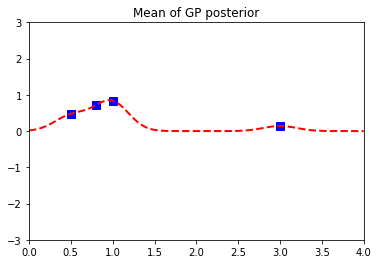

In [20]:
plt.plot(x_t,y_t, 'bs', ms=8)
plt.plot(x_s,f_s, 'r--', lw=2)
plt.axis([x_min,x_max, -3, 3])
plt.title('Mean of GP posterior')
plt.show()

In [21]:
# compute the covariance of test points
Cov_ss_post = K_ss - np.dot(M_ts.T, M_ts)

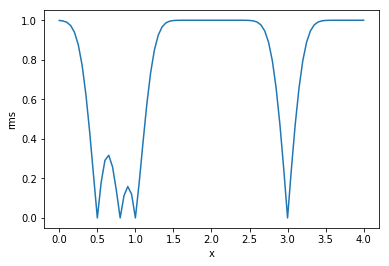

In [22]:
std_s = np.sqrt(np.diag(Cov_ss_post))
plt.plot(x_s,std_s)
plt.xlabel('x')
plt.ylabel('rms')
plt.show()

In [23]:
# Draw 3 samples from the posterior at our test points.
L_ss_post = np.linalg.cholesky(Cov_ss_post+1e-10*np.eye(n_s))
f_s_post = f_s.reshape(-1,1) + np.dot(L_ss_post, np.random.normal(size=(n_s,3)))

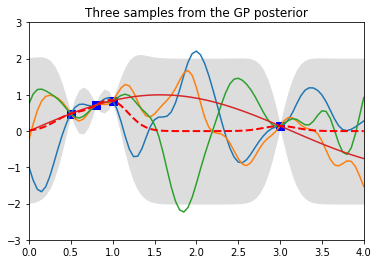

In [24]:
plt.plot(x_t,y_t, 'bs', ms=8)
plt.plot(x_s, f_s_post)
plt.plot(x_s, true_function(x_s))
plt.gca().fill_between(x_s.flat, f_s-2*std_s, f_s+2*std_s, color="#dddddd")
plt.plot(x_s, f_s, 'r--', lw=2)
plt.axis([x_min,x_max, -3, 3])
plt.title('Three samples from the GP posterior')
plt.show()

# Redo with GPy

In [25]:
# setup kernel
k1 = GPy.kern.RBF(input_dim=1, variance=1., lengthscale=length)

In [26]:
# setup main GP object
m1 = GPy.models.GPRegression(x_t,y_t,k1,noise_var=noise_var)
print('log marginal likelihood',m1.log_likelihood())

log marginal likelihood -3.836856954837712


In [27]:
from IPython.display import display
display(m1)

GP_regression.,value,constraints,priors
rbf.variance,1.0,+ve,
rbf.lengthscale,0.2,+ve,
Gaussian_noise.variance,1e-10,+ve,


 /Users/font/Programs/Others/anaconda3/lib/python3.6/site-packages/matplotlib/figure.py:2369: UserWarning:This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.


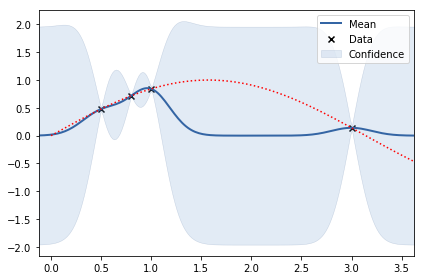

In [28]:
fig = m1.plot()
plt.plot(x_s,true_function(x_s),':',color='red')
plt.show()

In [29]:
m1.optimize(messages=True)

 /Users/font/Programs/Others/anaconda3/lib/python3.6/site-packages/matplotlib/figure.py:2369: UserWarning:This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.


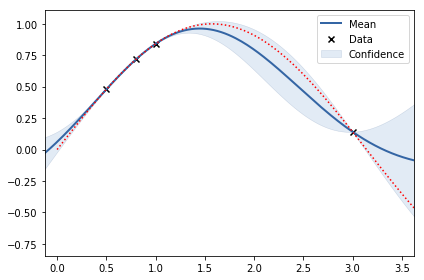

In [30]:
fig = m1.plot()
plt.plot(x_s,true_function(x_s),':',color='red')
plt.show()

In [31]:
# setup linear kernel
k2 = GPy.kern.Linear(input_dim=1,variances=1.0,ARD=False)

In [32]:
# setup main GP object
m2 = GPy.models.GPRegression(x_t,y_t,k2,noise_var=noise_var)
print('log marginal likelihood',m2.log_likelihood())

log marginal likelihood -53257941.07975715


In [33]:
display(m2)

GP_regression.,value,constraints,priors
linear.variances,1.0,+ve,
Gaussian_noise.variance,1e-10,+ve,


 /Users/font/Programs/Others/anaconda3/lib/python3.6/site-packages/matplotlib/figure.py:2369: UserWarning:This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.


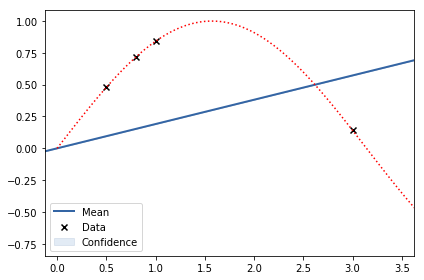

In [34]:
fig = m2.plot()
plt.plot(x_s,true_function(x_s),':',color='red')
plt.show()

In [35]:
m2.optimize(messages=True)

 /Users/font/Programs/Others/anaconda3/lib/python3.6/site-packages/matplotlib/figure.py:2369: UserWarning:This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.


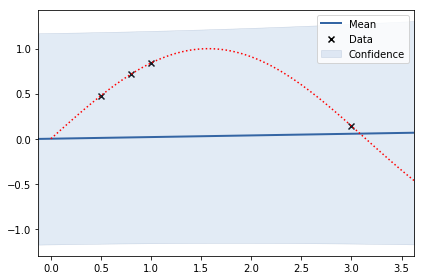

In [36]:
fig = m2.plot()
plt.plot(x_s,true_function(x_s),':',color='red')
plt.show()

In [37]:
# combine kernels
k3 = k1+k2

In [38]:
# setup main GP object
m3 = GPy.models.GPRegression(x_t,y_t,k3,noise_var=noise_var)
print('log marginal likelihood',m3.log_likelihood())
display(m3)

log marginal likelihood 1.1206271014868718


GP_regression.,value,constraints,priors
sum.rbf.variance,0.34796222822219225,+ve,
sum.rbf.lengthscale,1.2224267050190036,+ve,
sum.linear.variances,0.003501174673582018,+ve,
Gaussian_noise.variance,1e-10,+ve,


 /Users/font/Programs/Others/anaconda3/lib/python3.6/site-packages/matplotlib/figure.py:2369: UserWarning:This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.


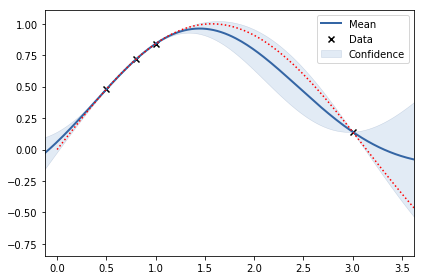

In [39]:
fig = m3.plot()
plt.plot(x_s,true_function(x_s),':',color='red')
plt.show()

In [40]:
m3.optimize(messages=True)

 /Users/font/Programs/Others/anaconda3/lib/python3.6/site-packages/matplotlib/figure.py:2369: UserWarning:This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.


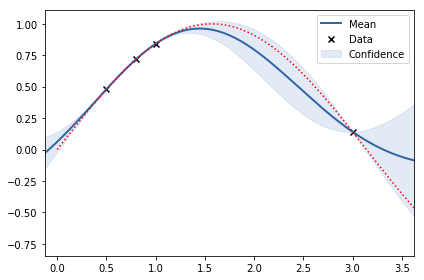

In [41]:
fig = m3.plot()
plt.plot(x_s,true_function(x_s),':',color='red')
plt.show()

In [42]:
print('log like RBF only',m1.log_likelihood())
print('log like linear only',m2.log_likelihood())
print('log like RBF+linear',m3.log_likelihood())

log like RBF only 1.1581015117307634
log like linear only -3.6751983468597214
log like RBF+linear 1.158101493164672
